In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

#External library pillow is an image library 
#that has pgm support
from PIL import Image

def readImages():
    #Read in images and format into matrix of size 10304x400

    #allocate image array to desired output size of 10304x400
    img_arr = np.zeros([10304, 400])

    #initialize iterator 
    k = 0

    #loop through number of participants (folders) 1-40
    for i in range(1, len(os.listdir('att_faces'))):
        #loop through individual images per participant 1-10
        for j in range(1, len(os.listdir('att_faces/s'+str(i)))+1):

            #save images to variable 
            images = 'att_faces/s'+str(i)+'/'+str(j)+'.pgm'

            #load image into PIL imager 
            img = Image.open(images)

            #assigned temp image to temporary numpy array 
            temp = np.array(img)

            #reshapre image to desired output size 10304x400
            img_arr[:,k] = np.reshape(temp, (temp.shape[0] * temp.shape[1]))

            #update iterator 
            k += 1
    return img_arr.astype(float)

In [2]:
#Split datasets
def splitData(image_array, test_start, train_start, gallery_start):

    # create arrays of size 10304xnum of cols for each set 
    test_set = np.zeros([10304,80])
    train_set = np.zeros([10304,160])
    gallery_set = np.zeros([10304,160])

    #set counter 
    k = 0

    #loop len(num of cols) - 10 with step size of 10
    #each 10 columns represent a different image of an individual
    for j in range(0,391,10):
        #save first and second image for each person in the test set 
        test_set[:,k] = image_array[:,j+test_start]
        #update counter each time 
        k += 1
        test_set[:,k] = image_array[:,j+(test_start+1)] 
        k += 1 

    #set counter    
    k = 0

    #loop len(num of cols) - 10 with step size of 10
    #each 10 columns represent a different image of an individual
    for j in range(0, 391,10):
        #save third to sixth image per person in training set 
        train_set[:,k] = image_array[:,j+train_start]
        #update counter each time 
        k += 1 
        train_set[:,k] = image_array[:,j+(train_start+1)]
        k += 1 
        train_set[:,k] = image_array[:,j+(train_start+2)]
        k += 1 
        train_set[:,k] = image_array[:,j+(train_start+3)]
        k += 1

    #set counter
    k = 0

    #loop len(num of cols) - 10 with step size of 10
    #each 10 columns represent a different image of an individual
    for j in range(0, 391, 10):
        #save seventh to 10th image per person in gallery set
        gallery_set[:,k] = image_array[:,j+gallery_start]
        #update counter each time 
        k += 1
        gallery_set[:,k] = image_array[:,j+(gallery_start+1)]
        k += 1
        gallery_set[:,k] = image_array[:,j+(gallery_start+2)]
        k += 1
        gallery_set[:,k] = image_array[:,j+(gallery_start+3)]
        k += 1
    
    return test_set, train_set, gallery_set

In [3]:
#Calculate the mean of each row in the datasets
def meanCenterData(test_data, train_data, gallery_data):
    
    #axis 0 calculates mean through rows 
    test_means = np.mean(test_data, axis=0)
    train_means = np.mean(train_data, axis=0)
    gallery_means = np.mean(gallery_data, axis=0)
    
    #center the data by subtracting the mean of each row 
    #with the original data set
    test_centered = np.subtract(test_data, test_means)
    train_centered = np.subtract(train_data, train_means)
    gallery_centered = np.subtract(gallery_data, gallery_means)
    
    return test_centered, train_centered, gallery_centered

In [10]:
#Compute Eigenfaces
def eigenface(train):
    
    #Computing the training set covariance matrix 
    cov_train = train.T.dot(train)
    
    #get the eigenvalues and eigenvectors of the covariance matrix 
    eigenval, eigenvec = np.linalg.eig(cov_train)
    
    #sorting the eigenvalues and eigenvectors of the covariance matrix
    idx = np.argsort(eigenval)[::-1]
    eigenval = eigenval[idx]
    eigenvec = eigenvec[:,idx]
    
    #Reconstruct correct eigenvectors
    E = train.dot(eigenvec)
    
    return E, eigenval

In [11]:
def inference(eigenvectors, eigenvalue, basis_size, test, gallery):
    
    #preparing the data for comparison 
    #create a basis set out of the first 50 cols of eigenvec
    basis = eigenvectors[:,0:basis_size]
    
    #initialize projection vars 
    p = 0
    t = 0
    
    #initialize sizes of test gallery and basis sets 
    N = test.shape[1]
    M = gallery.shape[1]
    B = basis.shape[1]
    
    #preallocate size of weight matrices for testing and gallery 
    T_Weights = np.zeros((N, 50))
    G_Weights = np.zeros((M, 50))
    
    #initialized distance matrix filled with zeros
    d = np.zeros((N,M),dtype=object)
    
    #Compute the projected_image for each test and gallery set 
    for i in range(0, B):
        for j in range(0, N):
            p += basis[:,i].T.dot(test[:,j])*basis[:,i]
            
    for i in range(0, B):
        for j in range(0, M):
            t += basis[:,i].T.dot(gallery[:,j])*basis[:,i]
            
    #compute the weights to find the approximation of each of the images 
    #in both the testing and gallery datasets
    for I in range(0, B):
        for J in range(0, N):
            T_Weights[J,I] = basis[:,I].T.dot(test[:,J])
            
    #Computed weights for the gallery dataset 
    for I in range(0, B):
        for J in range(0, M):
            G_Weights[J,I] = basis[:,I].T.dot(gallery[:,J])
            
    #to compare the images in the training and gallery data set we 
    #need to calculate the distance 
    #to see how similar or different images are 
    for I in range(0,N):
        for J in range(0,M):
            for K in range(0,basis.shape[1]):
                d[I,J] += (1/eigenvalue[K])*(T_Weights[I,K]-G_Weights[J,K])**2
       
    #Create testing and gallery vectors 
    #testing vector has size 1x80 
    #gallery vector has size 1x160
    testing_data = np.arange(1,41)#create array of size 1-40 (41 exclusive)
    #1,1,2,2...40,40
    testing = np.repeat(testing_data,2)#repeat repeats each element in array

    gallery_data = np.arange(1,41)#create array of size 1-40 (41 exclusive)
    #1,1,1,1,2,2,2,2...40,40,40,40
    gallery = np.repeat(gallery_data, 4)#repeat repeats each element in array

    #initialize win and count variables to keep track of wins and loses 
    #used to calc final percentage 
    win_count = 0
    loss_count = 0
    
    #loop through length of distance matrix 
    for rows in range(len(d)):
        #find the index of the minimum element in each element
        index_of_mu = np.argmin(d[rows,:])
        #conditional to compare if the testing is the same as the min distance 
        #in the gallery set 
        if (testing[rows] == gallery[index_of_mu]):
            #increment wins 
            win_count += 1
        else:
            #increment losses 
            loss_count += 1
    
    #calculate percentage 
    count_pct = (win_count/(win_count+loss_count))*100
    
    return count_pct

In [70]:
def eigenvaluePlots(E):
    
    eigenface1 = np.reshape(E[:,0], (112,92)).astype(int)
    plt.imshow(eigenface1, cmap='gray')
    plt.title("5 Faces With Largest Eigenvalues")
    plt.show()
    
    eigenface2 = np.reshape(E[:,1], (112,92)).astype(int)
    plt.imshow(eigenface2, cmap='gray')
    plt.show()
    
    eigenface3 = np.reshape(E[:,2], (112,92)).astype(int)
    plt.imshow(eigenface3, cmap='gray')
    plt.show()
    
    eigenface4 = np.reshape(E[:,3], (112,92)).astype(int)
    plt.imshow(eigenface4, cmap='gray')
    plt.show()
    
    eigenface5 = np.reshape(E[:,4], (112,92)).astype(int)
    plt.imshow(eigenface5, cmap='gray')
    plt.show()
    
    eigenface6 = np.reshape(E[:,-1], (112,92)).astype(int)
    plt.imshow(eigenface6, cmap='gray')
    plt.title("5 Faces With Smallest Eigenvalues")
    plt.show()
    
    eigenface7 = np.reshape(E[:,-2], (112,92)).astype(int)
    plt.imshow(eigenface7, cmap='gray')
    plt.show()
    
    eigenface8 = np.reshape(E[:,-3], (112,92)).astype(int)
    plt.imshow(eigenface8, cmap='gray')
    plt.show()
    
    eigenface9 = np.reshape(E[:,-4], (112,92)).astype(int)
    plt.imshow(eigenface9, cmap='gray')
    plt.show()
    
    eigenface10 = np.reshape(E[:,-5], (112,92)).astype(int)
    plt.imshow(eigenface10, cmap='gray')
    plt.show()

# Part A

In [71]:
def trial_1():

    #call functions 
    #reads in all images, takes no arguments since image folder is the same 
    image_array = readImages()
    
    #splitting index starts at 0 
    #thus 0 = 1.pgm, 2 = 3.pgm ... 
    test, train, gallery = splitData(image_array, 0, 2, 6)
    
    #normalize the dataset by mean-centering each dataset 
    test_centered, train_centered, gallery_centered = meanCenterData(test, train, gallery)
    
    #calculate correct eigenvectors 
    E, eigenvalue = eigenface(train_centered)
    
    #find the mean of the original image matrix to find the average face of the entire dataset
    average_face = np.mean(image_array, axis=1)
    average_face = np.reshape(average_face, (112,92)).astype(int)
    plt.imshow(average_face, cmap='gray')
    plt.title("Average Face of Dataset")
    plt.show()
    
    #show eigenvalue plots 
    eigenvaluePlots(E)

    #changing the size of the basis set
    #call function 6 times and put result inside pandas df
    acc_1 = inference(E, eigenvalue, 5, test_centered, gallery_centered)
    acc_2 = inference(E, eigenvalue, 10, test_centered, gallery_centered)
    acc_3 = inference(E, eigenvalue, 20, test_centered, gallery_centered)
    acc_4 = inference(E, eigenvalue, 30, test_centered, gallery_centered)
    acc_5 = inference(E, eigenvalue, 40, test_centered, gallery_centered)
    acc_6 = inference(E, eigenvalue, 50, test_centered, gallery_centered)

    #show accuracy 
    data = {'First 5 Cols':[acc_1],'First 10 Cols':[acc_2],
            'First 20 Cols':[acc_3],'First 30 Cols':[acc_4],
            'First 40 Cols':[acc_5], 'First 50 Cols':[acc_6]}

    df = pd.DataFrame(data, index=['Percent correct'])
    
    return df, data

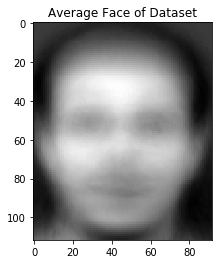

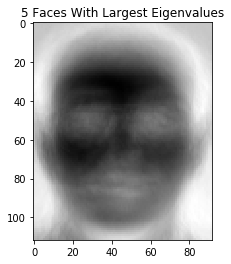

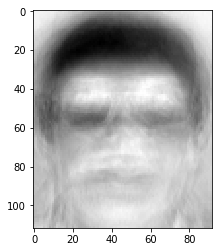

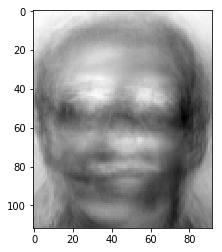

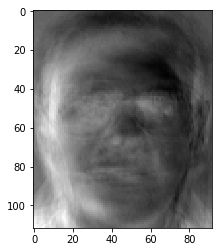

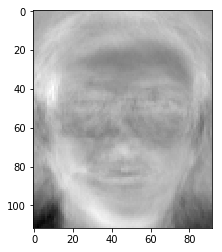

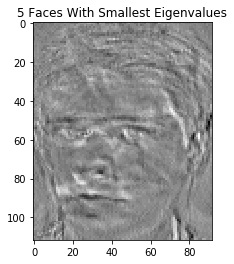

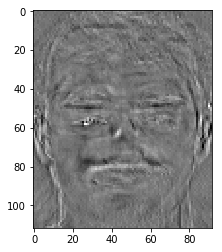

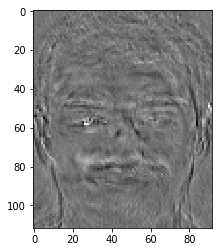

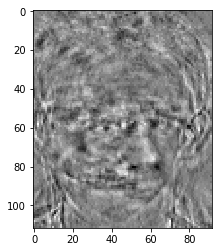

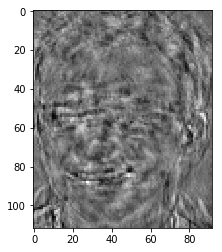

In [72]:
df, data = trial_1()

In [73]:
#accuracy output for part A
df

,First 5 Cols,First 10 Cols,First 20 Cols,First 30 Cols,First 40 Cols,First 50 Cols
Percent correct,62.5,83.75,91.25,91.25,91.25,91.25


# Part B

Text(0.5, 1.0, 'Basis Size Effecting Accuracy')

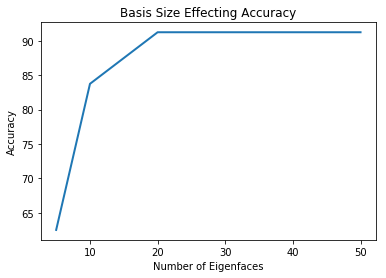

In [74]:
num_eigenfaces = [5, 10, 20, 30, 40, 50]
accuracy = list(data.values())
plt.plot(num_eigenfaces, accuracy, linewidth=2.0)
plt.ylabel('Accuracy')
plt.xlabel('Number of Eigenfaces')
plt.title('Basis Size Effecting Accuracy')

# Part C

In [75]:
def trial_2():

    #call functions 
    #reads in all images, takes no arguments since image folder is the same 
    image_array = readImages()
    #splitting index starts at 0 
    #thus 0 = 1.pgm, 2 = 3.pgm ... 
    test, train, gallery = splitData(image_array, 8, 0, 4)
    #normalize the dataset by mean-centering each dataset 
    test_centered, train_centered, gallery_centered = meanCenterData(test, train, gallery)
    #calculate correct eigenvectors 
    E, eigenvalue = eigenface(train_centered)

    #changing the size of the basis set
    #call function 6 times and put result inside pandas df
    acc_1 = inference(E, eigenvalue, 5, test_centered, gallery_centered)
    acc_2 = inference(E, eigenvalue, 10, test_centered, gallery_centered)
    acc_3 = inference(E, eigenvalue, 20, test_centered, gallery_centered)
    acc_4 = inference(E, eigenvalue, 30, test_centered, gallery_centered)
    acc_5 = inference(E, eigenvalue, 40, test_centered, gallery_centered)
    acc_6 = inference(E, eigenvalue, 50, test_centered, gallery_centered)

    #show accuracy 
    data = {'First 5 Cols':[acc_1],'First 10 Cols':[acc_2],
            'First 20 Cols':[acc_3],'First 30 Cols':[acc_4],
            'First 40 Cols':[acc_5], 'First 50 Cols':[acc_6]}

    df = pd.DataFrame(data, index=['Percent correct'])

    return df

In [76]:
trial_2()

,First 5 Cols,First 10 Cols,First 20 Cols,First 30 Cols,First 40 Cols,First 50 Cols
Percent correct,63.75,86.25,87.5,87.5,86.25,91.25
